In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import folium
from folium.plugins import HeatMap
import math
import bisect
import cv2, os, glob
import json
import torch
from tqdm import tqdm
from tqdm.std import trange
import copy
import pandas as pd
from scipy import interpolate
from copy import deepcopy

import argparse
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
from maskrcnn_benchmark.config import cfg


IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# red, green, blue, yellow, pink, sea, wite, green
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i%m]

import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [221]:
import argparse
import cv2, os, glob
from collections import OrderedDict
import torch
import numpy as np
from copy import deepcopy
from scipy import interpolate
from tqdm import tqdm
import logging

import maskrcnn_benchmark.engine.post_process as util
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
import tools as tools


### input line: [[x0, x1...],...], [[y0, y1...]...]
### output: list[lines_info]
def create_polyline_for_lines(in_x, in_y, default_sample):
    lines_info = list()
    for i, (xl, yl) in enumerate(zip(in_x, in_y)): # for x/y list of each line
        if len(yl) <= 1:
            continue # drop 1 point line
        
        # ??? merge_point_with_same_y(yl,xl)
        
        y_max, y_min = max(yl), min(yl)

        yl, xl = np.array(yl), np.array(xl)
        ind = np.argsort(yl) # small->big
        yl, xl = yl[ind], xl[ind]

        pt_lower = np.array([ xl[-1], yl[-1] ])
        pt_upper = np.array([ xl[0], yl[0] ])
        
        # choose k
        if len(yl) <= 3:
            k = len(yl) - 1
            # print("pts len: {}, thus choose k: {}".format(len(yl), k))
            tck = interpolate.splrep(x=yl, y=xl, s=0, k=k)
        else:
            tck = interpolate.splrep(x=yl, y=xl, s=0)
        
        # create sampled y in range of (y_min, y_max)
        y_sample = default_sample[default_sample >= y_min]
        y_sample = y_sample[y_sample <= y_max]

        x_sample = interpolate.splev(x=y_sample, tck=tck, der=0)
        lines_info.append({
            'tck': tck,
            'y_max': y_max,
            'y_min': y_min,
            'pt_lower':pt_lower, # bound in lower image
            'pt_upper':pt_upper, # bound in upper image
        })
    return lines_info

# input line: list[lines_info]
# output: cluster of lines' id 
def merge_close_line(lines, thresh=15):
    result = list()
    selected = [False] * len(lines) # [False, ... False]
    for n in range(len(lines)):
        if selected[n]:
            continue
        result.append(list()) # create a new line (contain ids)
        result[-1].append(n)
        selected[n] = True
        for t in range(n + 1, len(lines)):
            if selected[t]:
                continue
            dis = compute_dist(lines[n], lines[t])
            if dis <= thresh: # find close line(t-th) of n-th line
                
                selected[t] = True 
                result[-1].append(t) # merge t-th lane
    return result


# input line: lines_info
def compute_dist(l1, l2):
    tck1 = l1['tck']
    tck2 = l2['tck']
    upper_bound = max(l1['y_min'], l2['y_min'])
    lower_bound = min(l1['y_max'], l2['y_max'])
    
    if upper_bound >= lower_bound:
        # seprated line
        # print("line seprated in y")
        if l1['y_max'] <= l2['y_min']:
            p1, p2 = l1['pt_lower'], l2['pt_upper']
            dist = np.sqrt(np.sum( (p1 - p2)**2 )) 
            return dist 
        elif l2['y_max'] <= l1['y_min']:
            p1, p2 = l2['pt_lower'], l1['pt_upper']
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist
        else:
            print("error")
            return 1e6
    else: 
        # overlaped line
        # print("overlaped line")
        ys_sample = np.arange(upper_bound, lower_bound, step=2.)
        xs_sample1 = interpolate.splev(x=ys_sample, tck=tck1, der=0)
        xs_sample2 = interpolate.splev(x=ys_sample, tck=tck2, der=0)
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)
        return dist_sum


def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):
        
        if len(lane_y) < 3:
            out_x.append(lane_x)
            out_y.append(lane_y)
            continue

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y

# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y


def merge_point_with_same_y(in_x, in_y):
    new_in_x, new_in_y = list(), list()

    for lid, (xl, yl) in enumerate(zip(in_x, in_y)):
        new_xl, new_yl = list(), list()
        selected = [False] * len(yl)

        for i in range(len(yl)):
            if selected[i]:
                continue # ignore visited or merged point
            xi_sum = xl[i]
            xi_cnt = 1
            selected[i] = True

            for j in range(i+1, len(yl)):
                if selected[j]: # ignore merged point
                    continue
                if yl[j] == yl[i]: # merge this point
                    selected[j] = True
                    xi_sum += xl[j]
                    xi_cnt += 1
            new_yl.append(yl[i])
            new_xl.append(xi_sum / xi_cnt)
        if len(new_yl) <= 1:
            continue # ignore 1 point line
        new_in_x.append(new_xl)
        new_in_y.append(new_yl)
    return new_in_x, new_in_y


### input: lines[ line[ pt[x,y]... ]... ] and points sorted along y
def fit_polylines_orig(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    
    xls, yls =merge_point_with_same_y(xls, yls)
    
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) <=2: # drop 2 points line
            continue
        
        if len(yl) <= 3:
            k = len(yl) - 1
            tck = interpolate.splrep(x=yl, y=xl, s=1, k=k)
        else:
            tck = interpolate.splrep(x=yl, y=xl, s=1, k=3)

        new_line = list()
        y_min, y_max = yl[0], yl[-1]
        if (y_max - y_min) <= 3.:
            ys_sample = np.array([y_min, y_max])
        else:
            ys_sample = np.arange(y_min, y_max, step=3.)

        xs_sample = interpolate.splev(x=ys_sample, tck=tck, der=0)
        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)
    return new_lines

#from scipy.optimize import curve_fit
#def polyline(x, a, b, c, d, e, f):
#    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
#def polyline(x,a,b,c):
#    return a*np.exp(-b*x)-c

def fit_polylines(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    
    xls, yls = merge_point_with_same_y(xls, yls)
    
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) <=2: # drop 2 points line
            continue
        

        new_line = list()
        y_min, y_max = yl[0], yl[-1]
        if (y_max - y_min) <= 3.:
            ys_sample = np.array([y_min, y_max])
        else:
            ys_sample = np.arange(y_min, y_max, step=3.)

        #xs_sample = interpolate.splev(x=ys_sample, tck=tck, der=0)
        #new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        #new_lines.append(new_line)
        
        
        #popt, pcov = curve_fit(polyline, xdata=yl, ydata=xl)
        #xs_sample = polyline(ys_sample, *popt)
        
        fitted = np.polyfit(yl, xl, 7)[::-1]
        xs_sample = np.zeros(len(ys_sample))
        for i in range(len(fitted)):
            xs_sample += fitted[i]*ys_sample**i

        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)
        
        
    return new_lines


def drop_short_line_orig(in_x, in_y, thresh=60.):
    out_x, out_y = list(), list()
    for xl, yl in zip(in_x, in_y):
        dist = np.sqrt( (xl[0] - xl[-1])**2 + (yl[0] - yl[-1])**2 )
        if dist > thresh:
            out_x.append(xl)
            out_y.append(yl)
    return out_x, out_y

def drop_short_line(lines, thresh=60.):
    outlines = list()
    for l in lines:
        dist = np.sqrt( (l[0][0] - l[-1][0])**2 + (l[0][1] - l[-1][1])**2 )
        if dist > thresh:
            outlines.append(l)
    return outlines


def add_pts_to_image_edge(lines):
    input_width = 1280-1
    input_height = 720-1
    interval = 3.2*2.5
    
    new_lines = list()
    for line in lines:
        x_pt_list = [pt[0] for pt in line]
        y_pt_list = [pt[1] for pt in line]

        max_y = y_pt_list[-1] # bottom pt
        if max_y < input_height: # 255
            y1 = y_pt_list[-2]
            y2 = y_pt_list[-1]
            x1 = x_pt_list[-2]
            x2 = x_pt_list[-1]

            # add points from points(max_y) to img bottom
            while max_y < input_height: # 255
                break_mark = False
                y_new = max_y + interval # 3.2(256/80)
                x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                if x_new < 0:
                    x_new = 0.1
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                elif x_new > input_width:
                    x_new = input_width
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                if y_new > input_height :
                    y_new = input_height
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                elif y_new < 0:
                    y_new = 0.1
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                # check if x/y is valid
                #if ( x_new > input_width or x_new < 0 or y_new > input_height or y_new < 0):
                #    break
                x_pt_list.append(x_new)
                y_pt_list.append(y_new)
                max_y = y_new
                if break_mark:
                    break
        new_line = [[x,y] for x, y in zip(x_pt_list, y_pt_list)] 
        new_lines.append(new_line)
    return new_lines

def merge_close_line_in_group(lines, thresh=15):
    result = list()
    selected = [False] * len(lines) # [False, ... False]
    for n in range(len(lines)):
        if selected[n]:
            continue
        result.append(list()) # create a new line (contain ids)
        # result[-1].append(n)
        result[-1].extend(n)
        selected[n] = True
        for t in range(n + 1, len(lines)):
            if selected[t]:
                continue
            dis = compute_dist(lines[n], lines[t])
            if dis <= thresh: # find close line(t-th) of n-th line
                
                selected[t] = True 
                # result[-1].append(t) # merge t-th lane
                result[-1].extend(t) # merge t-th lane
    return result


In [2]:
inputs = []
for i in range(4):
    path = "exp/oct26/inference/aicom_lane_test/oct26_res01_r{}.pth".format(i)
    temp = torch.load(path, map_location=torch.device("cpu"))
    inputs.append(temp)

In [142]:
outputs_dict = torch.load("exp/oct23/inference/aicom_lane_test/oct23_debug01_m_0.pth", 
                          map_location=torch.device("cpu"))
test_imgs = outputs_dict["test_images"]

In [4]:
datas = {}
for i in range(4):
    predictions = inputs[i]['predictions']
    for k,v in predictions.items():
        datas[k] = v

In [147]:
def get_imgs(idx):
    img_path = test_imgs[idx].split('/')[-1]
    return cv2.imread('datasets/lane_detection/test/images/'+img_path)

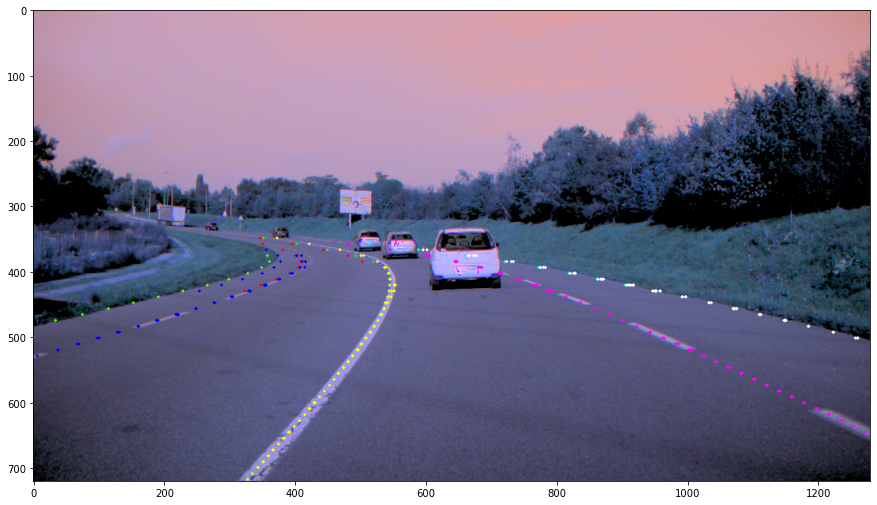

In [94]:
rx, ry = 1280/512.0, 720/256.0
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

# 53235 13122 53237 24049 53235 47154 7994 7995 45315 161 2570 2739 7
# 45315 47154 46000
# 2, 7, 8, 9, 10, 11, 13?, 16snow, 18 7906
idx = 7336 # 27207 45011 45683
groups = datas[idx]

img_path = test_imgs[idx].split('/')[-1]

img = cv2.imread('datasets/lane_detection/test/images/'+img_path)

for idx, lines in enumerate(groups):
    for idxx, pts in enumerate(lines):
        for i in range(len(pts)-1):
            x1 = int(pts[i][0]*rx)
            y1 = int(pts[i][1]*ry)
            x2 = int(pts[i+1][0]*rx)
            y2 = int(pts[i+1][1]*ry)
            cv2.circle(img, (x1,y1), 2, color[idx], -1)
            cv2.circle(img, (x2,y2), 2, color[idx], -1)
            # cv2.line(img, (x1,y1), (x2,y2), color[idx], 1)

            
plt.figure(figsize=(15, 15))
plt.imshow(img)

plt.show() 

In [208]:
def seprate_and_merge_group_to_line(group):
    lines_with_fit = create_fit_for_sorted_lines(group)
    groups_by_id = create_groups_by_distance(lines_with_fit)
    # print(groups_by_id)
    groups = list()
    for idxs in groups_by_id:
        outline = list()
        for idx in idxs:
            outline.extend( lines_with_fit[idx]["line"] )
            # outline.extend( group[idx] )
        groups.append(outline)
     
    # asc sort along y 
    for i in range(len(groups)):
        groups[i] = sorted(groups[i], key=lambda p: p[1])
        
    return groups

def create_fit_for_sorted_lines(lines):
    outlines = list()
    for l in lines:
        l = sorted(l, key=lambda p: p[1])
        yl = [p[1] for p in l]
        xl = [p[0] for p in l]
        fitted = np.polyfit(yl, xl, 5)[::-1]
        outlines.append({"line": l, "fitted": fitted})
    return outlines

# there are lines in a group, this function seprate line far away
# into a new group
def create_groups_by_distance_orig(lines, thresh=15):
    groups = list()
    selected = [False] * len(lines) # [False, ... False]
    for n in range(len(lines)):
        if selected[n]:
            continue
        groups.append(list()) # create a new group
        groups[-1].append(n) # insert line id into this group
        selected[n] = True
        for t in range(n + 1, len(lines)):
            #if selected[t]:
            #    continue
            dis = compute_dist_with_fit(lines[n], lines[t])
            #print(n, t, dis)
            if dis <= thresh: # find close line(t-th) of line(n-th)
                selected[t] = True 
                groups[-1].append(t) # insert line id into this group
    return groups

# from lines, find close ones of line i, and not in visit list
def find_close_lines(lines, i, visit_list=[], close_list=[], thresh=15):
    close_lines = list()
    for j in range(len(lines)):
        if j == i:
            continue
        dis = compute_dist_with_fit(lines[j], lines[i])
        if dis <= thresh and j not in visit_list and j not in close_list:
            close_lines.append(j)
    return close_lines + visit_list

def create_groups_by_distance(lines, thresh=15):
    groups = list()
    selected = [False] * len(lines)
    for i in range(len(lines)):
        if selected[i]:
            continue
        #groups.append(list())
        #groups[-1].append(i)
        selected[i] = True
        close_list = list()
        close_list.append(i)
        visit_list = find_close_lines(lines, i)
        while len(visit_list) > 0:
            t = visit_list[0] # give a number id
            del visit_list[0]
            close_list.append(t)
            selected[t] = True
            visit_list = find_close_lines(lines, t, visit_list, close_list)
        # while end
        groups.append(close_list)
    return groups

# lwf1 and lwf2: line_with_fit
def compute_dist_with_fit(lwf1, lwf2):
    #l1 = sorted(l1, key=lambda p: p[1])
    #l2 = sorted(l2, key=lambda p: p[1])
    l1, l2 = lwf1["line"], lwf2["line"]
    f1, f2 = lwf1["fitted"], lwf2["fitted"]
    
    yl1 = [p[1] for p in l1]
    xl1 = [p[0] for p in l1]
    
    yl2 = [p[1] for p in l2]
    xl2 = [p[0] for p in l2]
    
    ub = max(yl1[0], yl2[0])
    lb = min(yl1[-1], yl2[-1])
    
    if ub >= lb: # seprated or connected
        #print("seprated or connected line")
        if yl1[-1] <= yl2[0]:
            p1, p2 = np.array([xl1[-1], yl1[-1]]), np.array([xl2[0], yl2[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 )) 
            return dist 
        elif yl2[-1] <= yl1[0]:
            p1, p2 = np.array([xl2[-1], yl2[-1]]), np.array([xl1[0], yl1[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist
        else:
            print("error")
            return 1e6
    else: # overlaped line
        #print("overlaped line")
        ys_sample = np.arange(ub, lb, step=3.0)
        xs_sample1 = np.zeros(len(ys_sample))
        for i in range(len(f1)):
            xs_sample1 += f1[i]*ys_sample**i
        xs_sample2 = np.zeros(len(ys_sample))
        for i in range(len(f2)):
            xs_sample2 += f2[i]*ys_sample**i
        
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)
        return dist_sum


In [1]:
img_idx = 27207 # 27207 45011 45683 7336
prediction = datas[img_idx]
#img_path = test_imgs[idx].split('/')[-1]
#img = cv2.imread('datasets/lane_detection/test/images/'+img_path)

### 1. seprate more groups in one original group
outlines = list()
for i, group in enumerate(prediction):
    # seprate group into more groups
    groups = seprate_and_merge_group_to_line(group)
    for line in groups:
        outlines.append(line)


NameError: name 'datas' is not defined

In [2]:
im = get_imgs(img_idx)
for lid, l in enumerate(outlines):
    for x,y in l:
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, color[lid], -1)
print(len(outlines))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

NameError: name 'get_imgs' is not defined

In [226]:
### 2.1 eliminate outlier
x_lines = [[pt[0] for pt in line] for line in outlines]
y_lines = [[pt[1] for pt in line] for line in outlines]
in_x, in_y = util.sort_along_y(x_lines, y_lines)
in_x, in_y = eliminate_out(in_x, in_y)
### 2.2 merge point with same y
in_x, in_y = util.sort_along_y_asc(in_x, in_y)
# in_x, in_y = merge_point_with_same_y(in_x, in_y)
### 2.3 drop short line
# in_x, in_y = drop_short_line(in_x, in_y, thresh=60.)

10


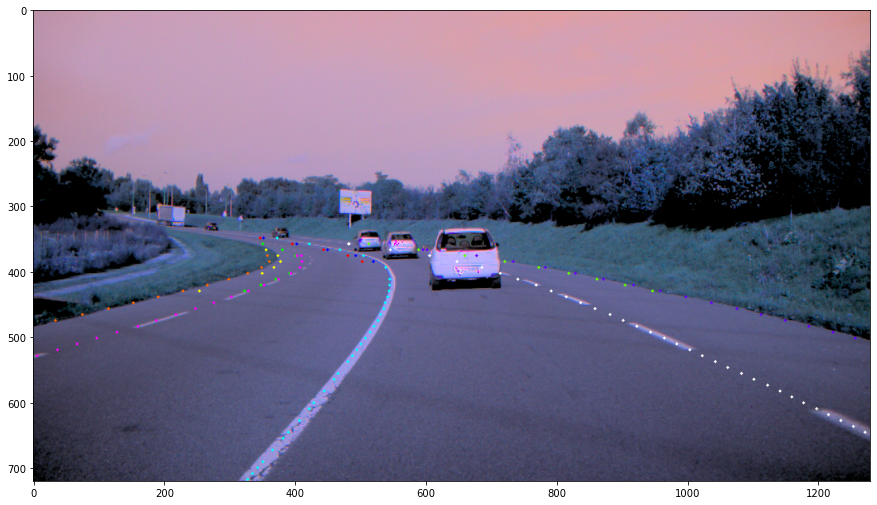

In [227]:
im = get_imgs(img_idx)
for lid, (xl, yl) in enumerate(zip(in_x, in_y) ):
    for x,y in zip(xl,yl):
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, color[lid], -1)
print(len(in_y))        
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [228]:
### 3. merge close line
lines = [[[x,y] for x,y in zip(xl,yl)] for xl,yl in zip(in_x, in_y)]
lines_with_fit = create_fit_for_sorted_lines(lines)
groups_by_id = create_groups_by_distance(lines_with_fit, thresh=15)
regrouped_lines = list()
for idxs in groups_by_id:
    outline = list()
    for idx in idxs:
        outline.extend( lines_with_fit[idx]["line"] )
        # outline.extend( group[idx] )
    outline = sorted(outline, key=lambda pt: pt[1])
    regrouped_lines.append(outline)

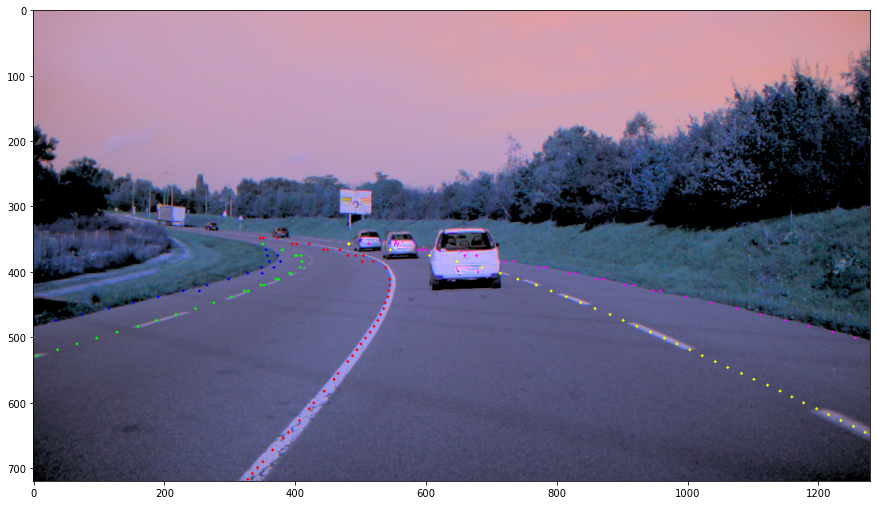

In [229]:
im = get_imgs(img_idx)
for lid, l in enumerate(regrouped_lines):
    for x,y in l:
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, color[lid], -1)
        
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

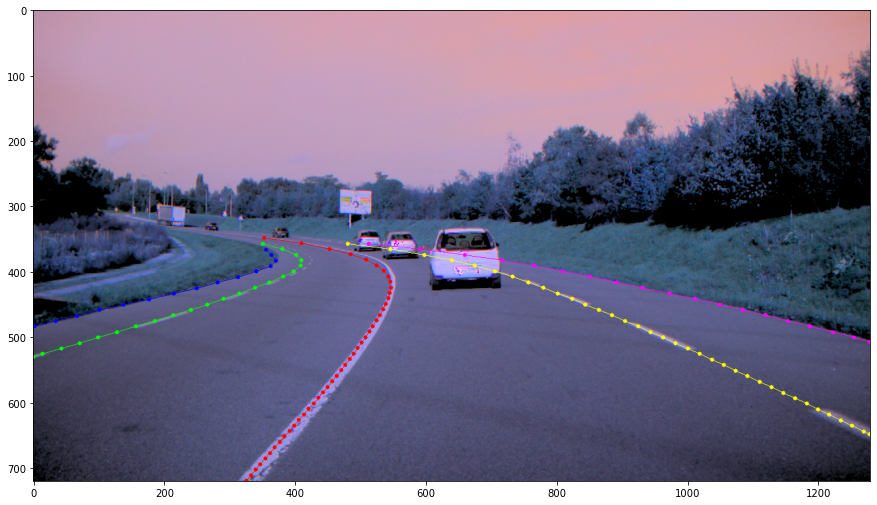

In [231]:
'''
### 3. merge close line
### 3.1 create polyline for each line
default_sample = np.arange(0., 256., step=3.)
lines_info = create_polyline_for_lines(in_x, in_y, default_sample)
### 3.2 find and merge close line
lid_cluster = merge_close_line(lines_info)
# output lines format lines[line[point[x,y],...],...]
regrouped_lines = list()
for i, lids in enumerate(lid_cluster):
    temp = list()
    for lid in lids:
        xl, yl = in_x[lid], in_y[lid]
        temp.extend([[x, y] for x, y in zip(xl, yl)])
    # sort along y
    temp = sorted(temp, key=lambda pt: pt[1])
    regrouped_lines.append(temp)
'''
### 4. remove close points
final_lines = fit_polylines(regrouped_lines, rx, ry)
final_lines = add_pts_to_image_edge(final_lines)

### 5. drop short line (thresh => 1280x720)
final_lines = drop_short_line(final_lines, thresh=200.)

####################################################################
lines = final_lines
im = get_imgs(img_idx)
'''
for i, line in enumerate(lines):
    for pt in line:
        x,y = int(pt[0]), int(pt[1])
        # x,y = int(pt[0]*rx), int(pt[1]*ry)
        cv2.circle(im, (x,y), 3, get_color(i), -1) 
'''        
for lid, pts in enumerate(lines):
    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])
        cv2.circle(im, (x1,y1), 3, color[lid], -1)
        cv2.circle(im, (x2,y2), 3, color[lid], -1)
        cv2.line(im, (x1,y1), (x2,y2), color[lid], 1) 
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [79]:
# merge lines in a group
# lines: lines in a group

def func1(lines, dist_thres=60.):
    in_x = [[p[0] for p in l] for l in lines]
    in_y = [[p[1] for p in l] for l in lines]
    default_sample = np.arange(0., 256., step=3.)
    lines_info = create_polyline_for_lines(in_x, in_y, default_sample)

    lid_cluster = merge_close_line(lines_info)
    regrouped_lines = list()
    for i, lids in enumerate(lid_cluster):
        temp = list()
        for lid in lids:
            xl, yl = in_x[lid], in_y[lid]
            temp.extend([[int(x), int(y)] for x, y in zip(xl, yl)])
        
        # sort along y
        temp = sorted(temp, key=lambda pt: pt[1])
        
        # check short line

        #dist = np.sqrt( (temp[0][0] - temp[-1][0])**2 + (temp[0][1] - temp[-1][1])**2 )
        #if dist < dist_thres:
        #    print("del line with dist {}".format(dist))
        #    continue
        #print(i, dist, temp)

        regrouped_lines.append(temp)
    
    return regrouped_lines

In [78]:

def drop_short_line(in_x, in_y, thresh=60.):
    out_x, out_y = list(), list()
    for xl, yl in zip(in_x, in_y):
        dist = np.sqrt( (xl[0] - xl[-1])**2 + (yl[0] - yl[-1])**2 )
        if dist > thresh:
            out_x.append(xl)
            out_y.append(yl)
    return out_x, out_y

### input line: [[x0, x1...],...], [[y0, y1...]...]
### output: list[lines_info]
def create_polyline_for_lines(in_x, in_y, default_sample):
    lines_info = list()
    for i, (xl, yl) in enumerate(zip(in_x, in_y)): # for x/y list of each line
        if len(yl) <= 1:
            continue # drop 1 point line
        
        # ??? merge_point_with_same_y(yl,xl)
        
        y_max, y_min = max(yl), min(yl)

        yl, xl = np.array(yl), np.array(xl)
        ind = np.argsort(yl) # small->big
        yl, xl = yl[ind], xl[ind]

        pt_lower = np.array([ xl[-1], yl[-1] ])
        pt_upper = np.array([ xl[0], yl[0] ])
        
        # choose k
        if len(yl) <= 3:
            k = len(yl) - 1
            # print("pts len: {}, thus choose k: {}".format(len(yl), k))
            tck = interpolate.splrep(x=yl, y=xl, s=0, k=k)
        else:
            tck = interpolate.splrep(x=yl, y=xl, s=0)
        
        # create sampled y in range of (y_min, y_max)
        y_sample = default_sample[default_sample >= y_min]
        y_sample = y_sample[y_sample <= y_max]

        x_sample = interpolate.splev(x=y_sample, tck=tck, der=0)
        lines_info.append({
            'tck': tck,
            'y_max': y_max,
            'y_min': y_min,
            'pt_lower':pt_lower, # bound in lower image
            'pt_upper':pt_upper, # bound in upper image
        })
    return lines_info

# input line: list[lines_info]
# output: cluster of lines' id 
def merge_close_line(lines, thresh=15):
    result = list()
    selected = [False] * len(lines) # [False, ... False]
    for n in range(len(lines)):
        if selected[n]:
            continue
        result.append(list()) # create a new line (contain ids)
        result[-1].append(n)
        selected[n] = True
        for t in range(n + 1, len(lines)):
            if selected[t]:
                continue
            dis = compute_dist(lines[n], lines[t])
            print(dis)
            if dis <= thresh: # find close line(t-th) of n-th line
                
                selected[t] = True 
                result[-1].append(t) # merge t-th lane
    return result


# input line: lines_info
def compute_dist(l1, l2):
    tck1 = l1['tck']
    tck2 = l2['tck']
    upper_bound = max(l1['y_min'], l2['y_min'])
    lower_bound = min(l1['y_max'], l2['y_max'])
    
    if upper_bound >= lower_bound:
        # seprated line
        # print("line seprated in y")
        if l1['y_max'] <= l2['y_min']:
            p1, p2 = l1['pt_lower'], l2['pt_upper']
            dist = np.sqrt(np.sum( (p1 - p2)**2 )) 
            return dist 
        elif l2['y_max'] <= l1['y_min']:
            p1, p2 = l2['pt_lower'], l1['pt_upper']
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist
        else:
            print("error")
            return 1e6
    else: 
        # overlaped line
        # print("overlaped line")
        ys_sample = np.arange(upper_bound, lower_bound, step=2.)
        xs_sample1 = interpolate.splev(x=ys_sample, tck=tck1, der=0)
        xs_sample2 = interpolate.splev(x=ys_sample, tck=tck2, der=0)
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)
        return dist_sum


In [81]:
import maskrcnn_benchmark.engine.post_process as util
def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):
        
        if len(lane_y) < 3:
            out_x.append(lane_x)
            out_y.append(lane_y)
            continue

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y

# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y
